## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Balance the trainning set](#Balance) ##
## [4. Create train, test and validation generators](#generators) ## 
## [5. Create a function to show Training Image Samples](#show) ## 
## [6. Create the Model](#model) ## 
## [7. Create a custom Keras callback to continue or halt training](#callback) ## 
## [8. Instantiate custom callback ](#callbacks) ##
## [9. Train the model](#train) ##
## [10. Define a function to plot the training data](#plot) ##
## [11. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [12 Save the model](#save) ##
## [13 Plot Validation Loss % change between epochs](#implot) ##
## [14 Analysis of the Validation Loss % change plot](#analysis) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm


<a id="makedf"></a>
# <center>Read in train, test and valid images and create train, test and validation data frames</center>

In [2]:
def make_dataframes():
    print('Enter the full path to the directory containing the train, test and valid sub directories')
    sdir=input(' ')
    dataset_names= ['train', 'test' ,'valid']
    train_path=os.path.join(sdir, r'C:\Users\Soft Zone\Downloads\Compressed\face_imageNew\train-20221113T144002Z-001\train')
    test_path=os.path.join(sdir, r'C:\Users\Soft Zone\Downloads\Compressed\face_imageNew\test-20221113T143932Z-001\test')
    valid_path=os.path.join(sdir, r'C:\Users\Soft Zone\Downloads\Compressed\face_imageNew\valid-20221113T144154Z-001\valid')
    path_list=[train_path, test_path, valid_path]   
    zip_list=zip(dataset_names, path_list)
    
    # generate train_df, test_df, valid_df
    for dataset, setpath in zip_list:
        filepaths=[]
        labels=[]
        classes=sorted(os.listdir(setpath))
        for klass in classes:
            classpath=os.path.join(setpath, klass)
            flist=sorted(os.listdir(classpath))           
            desc=f'{dataset:6s}-{klass:13s}'            
            for f in tqdm(flist, ncols=130, desc=desc):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if dataset =='train':
            train_df=df
        elif dataset == 'test':
            test_df=df
        else:
            valid_df=df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count, sdir
    

In [3]:
train_df, test_df, valid_df, classes, class_count, sdir=make_dataframes()

Enter the full path to the directory containing the train, test and valid sub directories
 C:\Users\Soft Zone\Downloads\Compressed\face_imageNew


valid -non_autistic : 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 25523.67it/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1263   the minimum files in any class in train_df is  1263
train_df length:  2526   test_df length:  200   valid_df length:  200
average image height=  441   average image width=  384  aspect ratio h/w=  1.1484375


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [4]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    #trgen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20 )
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
img_size=(200,200)
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2526 validated image filenames belonging to 2 classes.           for train generator 
Found 200 validated image filenames belonging to 2 classes.            for valid generator 
Found 200 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  50   test steps:  4  number of classes :  2


write a text file to the sdir that contains the classes information. This file named classes.txt. It can be used in association with  
the averaging_predictor.ipynb notebook. That notebook needs to know the classes information to make predictions on image files

In [5]:
content=str(classes)
for char in ['\'', '[', ']', ' ']:
    content=content.replace(char, '')
wpath=os.path.join(sdir,'classes.txt')
with open(wpath , 'w') as f:
    f.write(content)
# the file is stored in the sdir as classes.txt  

<a id="show"></a>
# <center>Create a function to show example training images</center>

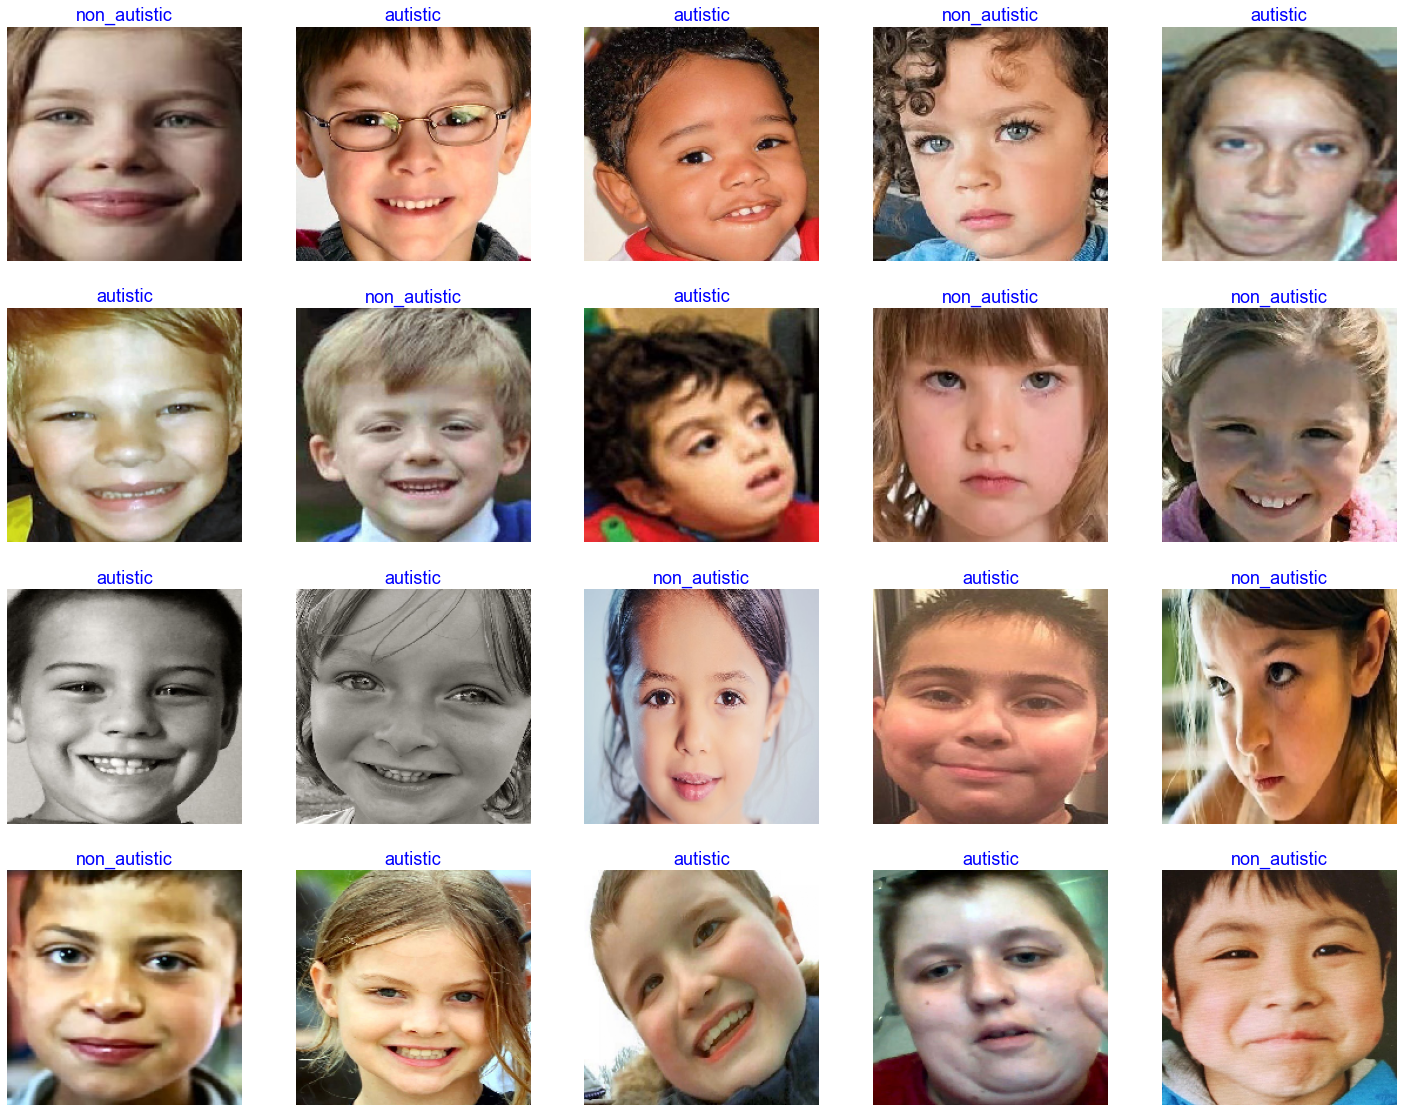

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB5</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [7]:
def make_model(img_size):  
    print('Enter the initial model learning rate. I recommend .002', flush=True)
    lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    return model

model=make_model(img_size)

Enter the initial model learning rate. I recommend .002
 0.002
43941136/43941136 [==============================] - 13s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            
            print (f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else: # validation loss increased
            pimprov=abs(pimprov)
            print (f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                print(f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}')
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [9]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have alwats found this to be true

In [10]:

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
127/127 [==============================] - ETA: 0s - loss: 6.0048 - accuracy: 0.6916
 validation loss of  4.0275 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights
127/127 [==============================] - 1199s 9s/step - loss: 6.0048 - accuracy: 0.6916 - val_loss: 4.0275 - val_accuracy: 0.7950
Epoch 2/40
127/127 [==============================] - ETA: 0s - loss: 3.0519 - accuracy: 0.8226
 validation loss of  2.4027 is 40.3440 % below lowest loss, saving weights from epoch 2   as best weights
127/127 [==============================] - 813s 6s/step - loss: 3.0519 - accuracy: 0.8226 - val_loss: 2.4027 - val_accuracy: 0.8200
Epoch 3/40
127/127 [==============================] - ETA: 0s - loss: 1.8333 - accuracy: 0.9030
 validation loss of  1.5883 is 33.8961 % below lowest loss, saving weight

Epoch 22/40
127/127 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9941
 validation loss of  0.3865 is  0.5112 % above lowest loss of  0.3845 keeping weights from epoch 18 as best weights
learning rate was automatically adjusted from 0.000003 to 0.000001
127/127 [==============================] - 778s 6s/step - loss: 0.1866 - accuracy: 0.9941 - val_loss: 0.3865 - val_accuracy: 0.9000
Epoch 23/40
127/127 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.9949
 validation loss of  0.3862 is  0.4399 % above lowest loss of  0.3845 keeping weights from epoch 18 as best weights
learning rate was automatically adjusted from 0.000001 to 0.000001
127/127 [==============================] - 776s 6s/step - loss: 0.1842 - accuracy: 0.9949 - val_loss: 0.3862 - val_accuracy: 0.8950
Epoch 24/40
127/127 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9901
 validation loss of  0.3856 is  0.2828 % above lowest loss of  0.3845 keeping w

<a id="plot"></a>
# <center>Define a function to plot the training data

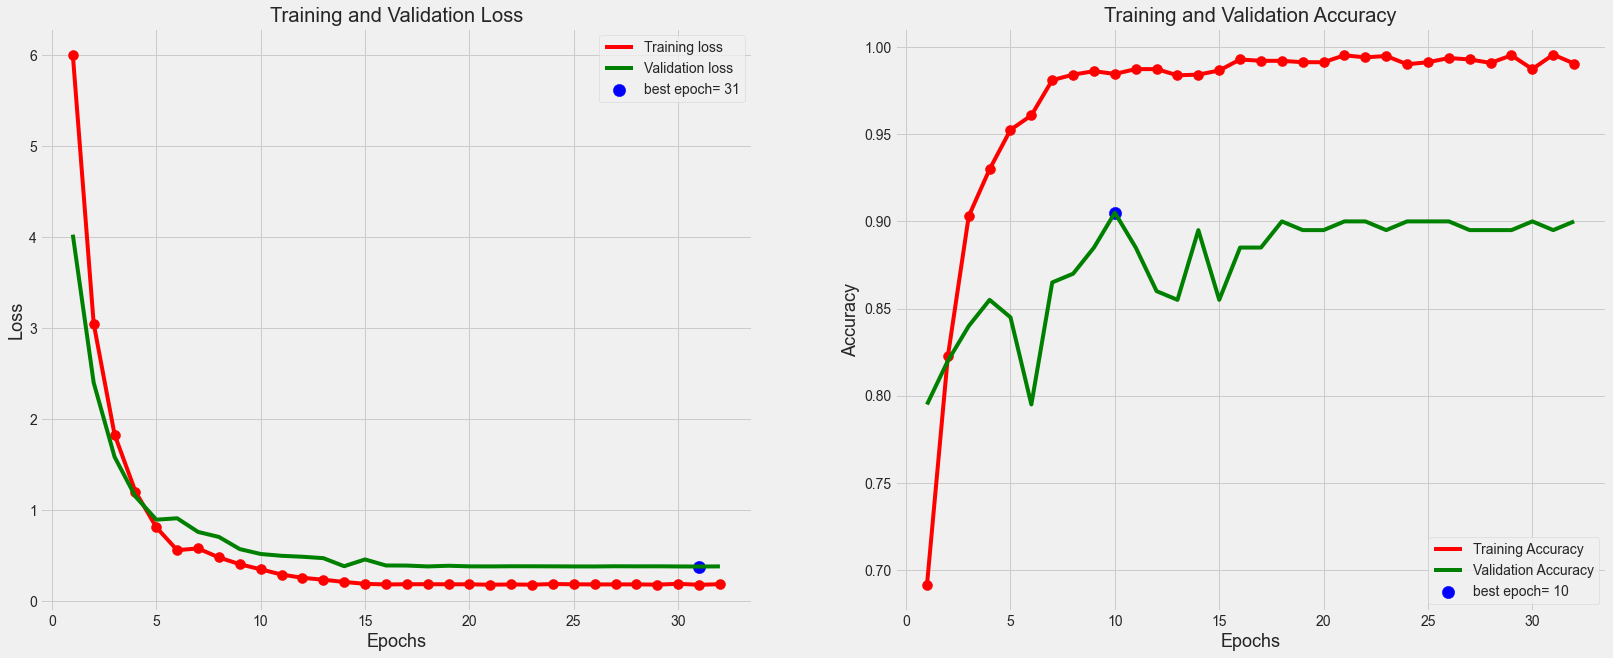

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

4/4 [==============================] - 34s 5s/step
there were 21 errors in 200 tests for an accuracy of  89.50


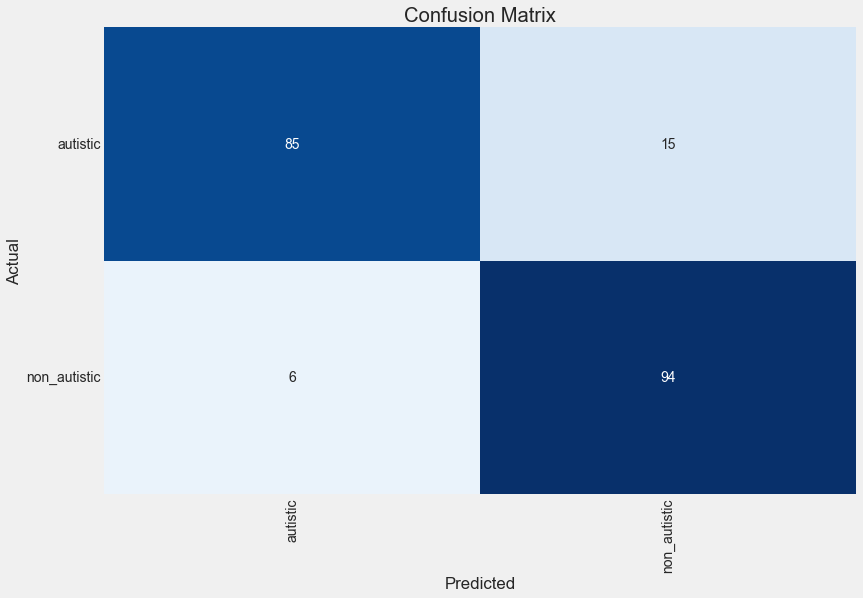

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic     0.9341    0.8500    0.8901       100
non_autistic     0.8624    0.9400    0.8995       100

    accuracy                         0.8950       200
   macro avg     0.8982    0.8950    0.8948       200
weighted avg     0.8982    0.8950    0.8948       200



In [12]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

We achieved an F1 score of 83,6% which is not to bad considering we limited the number of images in train_df to 150  
images per class and reduced the image size to 200 X 282. This was done to reduce training time at the expense of the  
F1 score. Did model did better than I expected given that the labels for the images were probably done by a human or  
humans based on a visual rather than an analytic criteria.

<a id="save"></a>
# <center>Save the model

In [13]:
working_dir=r'C:\Temp\Autism'
subject='fmri' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

model was saved as  C:\Temp\Autism\fmri_89.5.h5
